```
         Copyright Rein Halbersma 2020.
Distributed under the Boost Software License, Version 1.0.
   (See accompanying file LICENSE_1_0.txt or copy at
         http://www.boost.org/LICENSE_1_0.txt)
```

# Monte Carlo simulation for the game of Blackjack

In [1]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from doctrina.algorithms import dp, mc
from doctrina import spaces
import gym_blackjack_v1 as bj

env = gym.make('Blackjack-v1')
env.seed(47110815)

[47110815]

## The payout

In [2]:
pd.DataFrame(
    env.payout,
    index=bj.count_labels,  # player count
    columns=bj.count_labels # dealer count
)

,BUST,16,17,18,19,20,21,BJ
BUST,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
16,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
17,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0
18,1.0,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0
19,1.0,1.0,1.0,1.0,0.0,-1.0,-1.0,-1.0
20,1.0,1.0,1.0,1.0,1.0,0.0,-1.0,-1.0
21,1.0,1.0,1.0,1.0,1.0,1.0,0.0,-1.0
BJ,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


## Example 5.1: Blackjack

100%|██████████| 500000/500000 [00:16<00:00, 30044.49it/s]


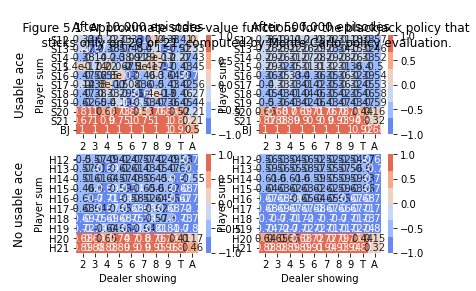

In [3]:
# Consider the policy that sticks if the player’s sum is 20 or 21, and otherwise hits.
stand_on_20 = np.full(spaces.shape(env.observation_space), bj.Action.h)
stand_on_20[bj.Hand.H20:(bj.Hand.H21 + 1), :] = bj.Action.s
stand_on_20[bj.Hand.S20:(bj.Hand.BJ  + 1), :] = bj.Action.s

# In any event, after 500,000 games the value function is very well approximated.
runs = [ 10_000, 500_000 ]
Vs, Ns = zip(*[ 
    mc.predict_ev(env, episodes, stand_on_20) 
    for episodes in runs 
])

options = {
    'vmin': min(env.reward_range), 
    'vmax': max(env.reward_range), 
    'cmap': sns.color_palette('coolwarm'), 
    'center': 0.,
    'annot': True, 
    'xticklabels': bj.card_labels
}

hands = [
    np.arange(bj.Hand.S12, bj.Hand.BJ  + 1),
    np.arange(bj.Hand.H12, bj.Hand.H21 + 1)
]

yticklabels = [ 
    np.array(bj.hand_labels)[hands[no_usable_ace]] 
    for no_usable_ace in range(2)
]

axopts = {
    'xlabel': 'Dealer showing',
    'ylabel': 'Player sum'
}

fig, axes = plt.subplots(nrows=2, ncols=len(runs))
fig.suptitle(
    """
    Figure 5.1: Approximate state-value functions for the blackjack policy that
    sticks only on 20 or 21, computed by Monte Carlo policy evaluation.
    """
)
rows = [ 'Usable ace', 'No usable ace']
cols = [ f'After {episodes:,} episodes' for episodes in runs ]

# https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
pad = 5 # in points

for ax, row in zip(axes[:,0], rows):
    ax.annotate(
        row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
        xycoords=ax.yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center', rotation=90
    )

for ax, col in zip(axes[0,:], cols):
    ax.annotate(
        col, xy=(0.5, 1), xytext=(0, pad),
        xycoords='axes fraction', textcoords='offset points',
        size='large', ha='center', va='baseline'
    )

for i, h in enumerate(hands):
    for r, _ in enumerate(runs):
        sns.heatmap(Vs[r][h, :], yticklabels=yticklabels[i], ax=axes[i, r], **options).set(**axopts)
plt.show()

In [4]:
V_mc = Vs[1]
V_mc_trunc = V_mc[1:, :]
pd.DataFrame(
    V_mc_trunc,
    index=bj.hand_labels[1:], 
    columns=bj.card_labels
).round(4)

,2,3,4,5,6,7,8,9,T,A
H2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
H3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
H4,-0.4694,-0.5948,-0.3628,-0.4350,-0.4244,-0.4286,-0.4009,-0.5385,-0.4961,-0.6455
H5,-0.4630,-0.4774,-0.4977,-0.4612,-0.4341,-0.5274,-0.4591,-0.5388,-0.5654,-0.6272
H6,-0.5301,-0.5007,-0.4471,-0.5584,-0.5042,-0.5120,-0.4663,-0.5092,-0.5668,-0.6714
H7,-0.4854,-0.5526,-0.5183,-0.5888,-0.5413,-0.4888,-0.4892,-0.4829,-0.5873,-0.6968
H8,-0.5177,-0.5778,-0.4953,-0.5444,-0.5719,-0.5565,-0.5148,-0.5696,-0.5741,-0.6863
H9,-0.5409,-0.5258,-0.5151,-0.4994,-0.4913,-0.5037,-0.4801,-0.5318,-0.5606,-0.6691
H10,-0.1386,-0.1262,-0.1054,-0.1070,-0.0832,-0.1173,-0.0582,-0.1067,-0.2155,-0.3793
H11,-0.0602,-0.0652,-0.0173,-0.0980,-0.0584,-0.0287,-0.0105,-0.0560,-0.1229,-0.3881


In [5]:
# Although we have complete knowledge of the environment in the blackjack task, it
# would not be easy to apply DP methods to compute the value function.
env.build_model()
policy = np.zeros(spaces.shape(env.state_space), dtype=int)
policy[:len(bj.Hand), :len(bj.Card)] = stand_on_20.copy()
policy = policy.reshape(spaces.size(env.state_space))
V, *_ = dp.V_policy_eval_deter_sync(env, policy, tol=1e-9)
V_dp = V.reshape(spaces.shape(env.state_space))
V_dp_trunc = V_dp[1:len(bj.Hand), :len(bj.Card)]
pd.DataFrame(
    V_dp_trunc, 
    index=bj.hand_labels[1:], 
    columns=bj.card_labels
).round(4)

,2,3,4,5,6,7,8,9,T,A
H2,-0.4431,-0.4409,-0.4386,-0.4366,-0.4295,-0.4147,-0.4110,-0.4151,-0.4871,-0.6084
H3,-0.4605,-0.4584,-0.4562,-0.4543,-0.4474,-0.4331,-0.4295,-0.4334,-0.5031,-0.6206
H4,-0.4783,-0.4762,-0.4741,-0.4723,-0.4656,-0.4518,-0.4483,-0.4521,-0.5195,-0.6331
H5,-0.4963,-0.4943,-0.4923,-0.4905,-0.4840,-0.4707,-0.4673,-0.4710,-0.5360,-0.6458
H6,-0.5144,-0.5125,-0.5105,-0.5088,-0.5026,-0.4897,-0.4865,-0.4900,-0.5527,-0.6585
H7,-0.5322,-0.5304,-0.5285,-0.5268,-0.5209,-0.5085,-0.5053,-0.5087,-0.5692,-0.6711
H8,-0.5539,-0.5521,-0.5503,-0.5488,-0.5431,-0.5314,-0.5285,-0.5316,-0.5887,-0.6862
H9,-0.5210,-0.5189,-0.5167,-0.5148,-0.5080,-0.4939,-0.4903,-0.4950,-0.5630,-0.6636
H10,-0.1314,-0.1271,-0.1227,-0.1188,-0.1048,-0.0760,-0.0685,-0.0797,-0.2170,-0.3908
H11,-0.0755,-0.0729,-0.0701,-0.0677,-0.0589,-0.0408,-0.0364,-0.0379,-0.1301,-0.3482


In [6]:
# In any event, after 500,000 games the value function is very well approximated.
pd.DataFrame(
    (V_mc_trunc - V_dp_trunc) / V_dp_trunc, 
    index=bj.hand_labels[1:], 
    columns=bj.card_labels
).style.format('{:,.2%}')

,2,3,4,5,6,7,8,9,T,A
H2,-100.00%,-100.00%,-100.00%,-100.00%,-100.00%,-100.00%,-100.00%,-100.00%,-100.00%,-100.00%
H3,-100.00%,-100.00%,-100.00%,-100.00%,-100.00%,-100.00%,-100.00%,-100.00%,-100.00%,-100.00%
H4,-1.86%,24.90%,-23.48%,-7.90%,-8.85%,-5.14%,-10.57%,19.11%,-4.51%,1.95%
H5,-6.71%,-3.43%,1.11%,-5.97%,-10.32%,12.05%,-1.77%,14.40%,5.47%,-2.87%
H6,3.06%,-2.30%,-12.42%,9.74%,0.32%,4.54%,-4.15%,3.91%,2.54%,1.95%
H7,-8.80%,4.19%,-1.93%,11.76%,3.92%,-3.87%,-3.20%,-5.09%,3.18%,3.84%
H8,-6.52%,4.64%,-10.00%,-0.80%,5.30%,4.71%,-2.58%,7.15%,-2.48%,0.01%
H9,3.82%,1.33%,-0.32%,-3.01%,-3.29%,1.98%,-2.07%,7.44%,-0.43%,0.83%
H10,5.49%,-0.73%,-14.05%,-9.95%,-20.64%,54.35%,-15.00%,33.96%,-0.72%,-2.94%
H11,-20.35%,-10.58%,-75.35%,44.78%,-0.97%,-29.65%,-71.15%,47.62%,-5.52%,11.46%


## Example 5.3: Solving Blackjack

100%|██████████| 500000/500000 [00:21<00:00, 23669.08it/s]


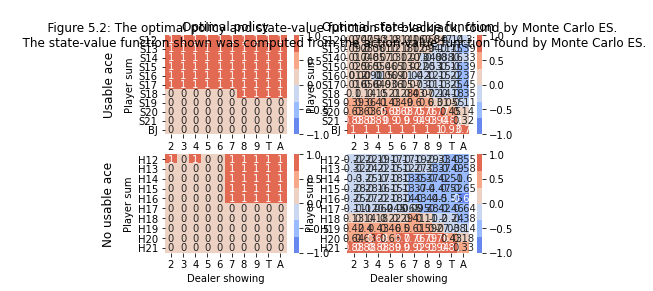

In [7]:
episodes = 500_000
policy0 = stand_on_20
policy, Q, N = mc.control_es(env, episodes, policy0)
assert (policy == Q.argmax(axis=2)).all()
policy = Q.argmax(axis=2)
V = Q.max(axis=2)

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.suptitle(
    """
    Figure 5.2: The optimal policy and state-value function for blackjack, found by Monte Carlo ES. 
    The state-value function shown was computed from the action-value function found by Monte Carlo ES.
    """
)
rows = [ 'Usable ace', 'No usable ace']
cols = [ 'Optimal policy', 'Optimal state-value function' ]

# https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
pad = 5 # in points

for ax, row in zip(axes[:,0], rows):
    ax.annotate(
        row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
        xycoords=ax.yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center', rotation=90
    )

for ax, col in zip(axes[0,:], cols):
    ax.annotate(
        col, xy=(0.5, 1), xytext=(0, pad),
        xycoords='axes fraction', textcoords='offset points',
        size='large', ha='center', va='baseline'
    )

for i, h in enumerate(hands):
    sns.heatmap(policy[h, :], yticklabels=yticklabels[i], ax=axes[i, 0], **options).set(**axopts)
    sns.heatmap(     V[h, :], yticklabels=yticklabels[i], ax=axes[i, 1], **options).set(**axopts)
plt.show()

In [8]:
V, policy, *_ = dp.V_value_iter(env)

In [9]:
pd.DataFrame(
    V.reshape(spaces.shape(env.state_space))[1:len(bj.Hand), :len(bj.Card)], 
    index=bj.hand_labels[1:], 
    columns=bj.card_labels
).round(4)

,2,3,4,5,6,7,8,9,T,A
H2,-0.0759,-0.0498,-0.0221,0.0137,0.0389,-0.0273,-0.1032,-0.1900,-0.3003,-0.4485
H3,-0.1005,-0.0689,-0.0363,0.0002,0.0245,-0.0574,-0.1309,-0.2151,-0.3218,-0.4655
H4,-0.1149,-0.0826,-0.0494,-0.0124,0.0111,-0.0883,-0.1593,-0.2407,-0.3439,-0.4829
H5,-0.1282,-0.0953,-0.0615,-0.0240,-0.0012,-0.1194,-0.1881,-0.2666,-0.3662,-0.5006
H6,-0.1408,-0.1073,-0.0729,-0.0349,-0.0130,-0.1519,-0.2172,-0.2926,-0.3887,-0.5183
H7,-0.1092,-0.0766,-0.0430,-0.0073,0.0292,-0.0688,-0.2106,-0.2854,-0.3714,-0.5224
H8,-0.0218,0.0080,0.0388,0.0708,0.1150,0.0822,-0.0599,-0.2102,-0.3071,-0.4441
H9,0.0744,0.1013,0.1290,0.1580,0.1960,0.1719,0.0984,-0.0522,-0.2181,-0.3532
H10,0.1825,0.2061,0.2305,0.2563,0.2878,0.2569,0.1980,0.1165,-0.0536,-0.2513
H11,0.2384,0.2603,0.2830,0.3073,0.3337,0.2921,0.2300,0.1583,0.0334,-0.2087


In [10]:
pd.DataFrame(
    policy.reshape(spaces.shape(env.state_space))[1:len(bj.Hand), :len(bj.Card)], 
    index=bj.hand_labels[1:], 
    columns=bj.card_labels
).applymap(lambda a: bj.action_labels[a].upper()).replace({'S': ' '})

,2,3,4,5,6,7,8,9,T,A
H2,H,H,H,H,H,H,H,H,H,H
H3,H,H,H,H,H,H,H,H,H,H
H4,H,H,H,H,H,H,H,H,H,H
H5,H,H,H,H,H,H,H,H,H,H
H6,H,H,H,H,H,H,H,H,H,H
H7,H,H,H,H,H,H,H,H,H,H
H8,H,H,H,H,H,H,H,H,H,H
H9,H,H,H,H,H,H,H,H,H,H
H10,H,H,H,H,H,H,H,H,H,H
H11,H,H,H,H,H,H,H,H,H,H


## Example 5.4: Off-policy Estimation of a Blackjack State Value

In [11]:
# We evaluated the state in which the dealer is showing a deuce, 
# the sum of the player’s cards is 13, and the player has a usable ace 
# (that is, the player holds an ace and a deuce, or equivalently three aces).
start = (bj.Hand.S13, bj.Card._2)

# The target policy was to stick only on a sum of 20 or 21, as in Example 5.1.
target_policy = stand_on_20

# The value of this state under the target policy is approximately −0.27726 
# (this was determined by separately generating one-hundred million episodes 
# using the target policy and averaging their returns).
episodes = 1_000_000
V, _ = mc.predict_ev(env, episodes, target_policy, start)
V[start]

100%|██████████| 1000000/1000000 [00:35<00:00, 28281.33it/s]


-0.27687199999999834

In [12]:
# Model-based policy evaluation using dynamic programming
V_dp[start]

-0.277204191825426

## References
[Reinforcement Learning, an Introduction, second edition] (http://incompleteideas.net/book/RLbook2020.pdf), Richard S. Sutton and Andrew G. Barto (2018).